In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from sklearn.pipeline import Pipeline

In [167]:

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mahha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [168]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
lemmatized_stop_words = [lemmatizer.lemmatize(w) for w in stop_words]
lemmatized_stop_words[:5]

['you', 'be', 'y', 'mustn', 'should']

In [169]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower()) for t in nltk.word_tokenize(doc) if t.isalpha()]

In [170]:
spams = pd.read_table("SMSSmapCollection.txt", sep='\t')
spamsTrain, spamsTest = train_test_split(spams, train_size=0.7, random_state=1)

In [171]:
nan_rows = spamsTrain[spamsTrain.isna().any(axis=1)]
nan_rows

,classe,message


In [172]:
pipe1 = Pipeline([('parse', TfidfVectorizer()), 
                 ('logistic', LogisticRegression())])

pipe2 = Pipeline([('parse', TfidfVectorizer(stop_words='english')), 
                 ('logistic', LogisticRegression())])

pipe3 = Pipeline([('parse', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))), 
                 ('logistic', LogisticRegression())])

In [173]:
pipe1.fit(spamsTrain['message'], spamsTrain['classe'])
pipe2.fit(spamsTrain['message'], spamsTrain['classe'])
pipe3.fit(spamsTrain['message'], spamsTrain['classe'])

score1 = pipe1.score(spamsTrain['message'], spamsTrain['classe'])
score2 = pipe1.score(spamsTest['message'], spamsTest['classe'])

score3 = pipe2.score(spamsTrain['message'], spamsTrain['classe'])
score4 = pipe2.score(spamsTest['message'], spamsTest['classe'])

score5 = pipe3.score(spamsTrain['message'], spamsTrain['classe'])
score6 = pipe3.score(spamsTest['message'], spamsTest['classe'])

In [174]:
# print("Training Score:", score1)
# print("Testing Score:", score2)
# print("Training Score (model2):", score4)
# print("Testing Score (model2):", score3)
# print("Training Score (model3):", score6)
# print("Testing Score (model3):", score5)

data = {
    "Model": ["Model 1 (Default)", "Model 2 (Stopwords)", "Model 3 (Stopwords + N-grams)"],
    "Training Score": [score1, score3, score5],
    "Testing Score": [score2, score4, score6]
}
results_df = pd.DataFrame(data)
results_df['Difference'] = results_df['Training Score'] - results_df['Testing Score']

results_df

,Model,Training Score,Testing Score,Difference
0,Model 1 (Default),0.983077,0.975478,0.007598
1,Model 2 (Stopwords),0.980000,0.974282,0.005718
2,Model 3 (Stopwords + N-grams),0.975385,0.973086,0.002298


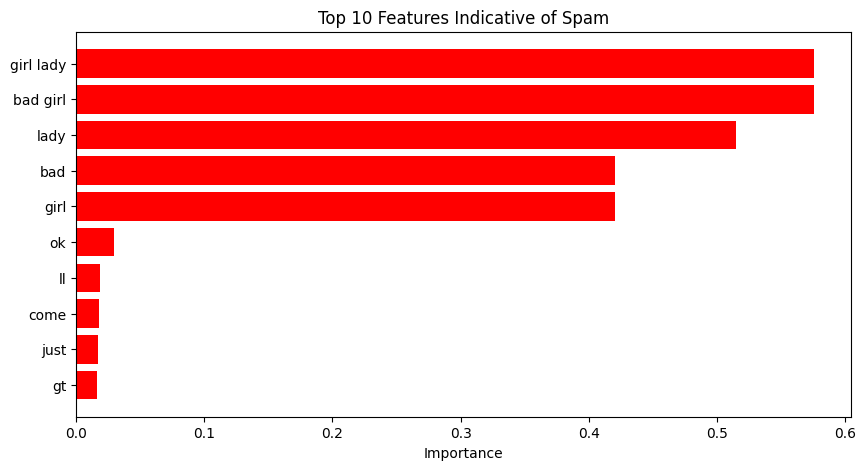

In [175]:
# model 3 is the most interesting one with n-grams and stop word removal, let's look at the most important features for spam classification

words = pipe3.named_steps["parse"].get_feature_names_out()
weights = pipe3.named_steps["logistic"].coef_[0]

feat_importance = pd.DataFrame({'feature': words, 'importance': weights})

top_spam = feat_importance.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(10, 5))
plt.barh(top_spam['feature'], top_spam['importance'], color='red')
plt.title('Top 10 Features Indicative of Spam')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.show()


In [184]:
def make_inference(messages, pipeline):
    
    predictions = pipeline.predict(messages)
    probabilities = pipeline.predict_proba(messages)
    
    results = pd.DataFrame({
        'Message': messages,
        'Prediction': predictions,
        'Confidence': [max(p) for p in probabilities]
    })

    return results

In [185]:
messages = ["Hey, are we still meeting for couscous at 7?", 
            "CONGRATULATIONS! You've won a 1000 gift card. Click here to claim now!",
            "URGENT! Your mobile number has been selected for a prize!",
            "Final Call: The Q1 Market Volatility Report for the Casablanca Stock Exchange is now available. Download the PDF to adjust your portfolio."]

make_inference(messages=messages, pipeline=pipe3)

,Message,Prediction,Confidence
0,"Hey, are we still meeting for couscous at 7?",ham,0.972404
1,CONGRATULATIONS! You've won a 1000 gift card. ...,spam,0.643774
2,URGENT! Your mobile number has been selected f...,spam,0.882500
3,Final Call: The Q1 Market Volatility Report fo...,ham,0.911125
